## Description:
######Model type = RNN
######Hidden layers = 32*2
######train seq_len = 200
######model id = new-rnn32-200
######model_name feature and printing more
######want to try epoch down and batch size down, but should keep same for experiment between LSTM and RMM
chars = sorted(list(set(text)))

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

Google Colab Mounting

In [6]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Hyper Params

In [7]:
#data
seq_len = 200
batch_size = 50
#model:
hidden_size = 32
n_layers = 2
cell_type = "rnn"
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = 'new-' + cell_type + str(hidden_size) + '-' + str(seq_len) #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"
print(model_id)

new-rnn32-200


Data Loading

In [8]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = sorted(list(set(text))) #set will not be the same every time, which cause loss of model before new-rnn-128-200
tchars = sorted(list(set(test_text)))
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))
print(chars)

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Data Preprocessing

In [9]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

432 torch.Size([201, 50])
22 torch.Size([201, 50])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, seq_len=seq_len, device='cpu', random=False): #npttext, 200 #0,300 #can use param to set random = True 
    if random:
        l = np.random.randint(0, len(data)-seq_len-2)
    else:
        l = 0
    r = l + seq_len +1
    testseq = data[l:r] #np
    testtensor = torch.LongTensor(testseq).view(seq_len+1, 1).to(device)

    hidden = model.init_hidden(batch_size=1, device=device)
    inp = testtensor[:-1]
    output, _ = model(inp, hidden)
    #print(output.size()) #200, 1, 67
    _, predicted = torch.max(output.data, 2)
    print("----------input data----------")
    #print(inp.size())
    print(tensor2s(inp.transpose_(0,1)[0])) #l:r
    print("----------prediction----------")
    #print(predicted.size())
    print(tensor2s(predicted.transpose_(0,1)[0]))


Test Functionality

In [14]:
def test_model(cell_type="rnn", device='cpu'): #not training/loaded model,create new to test
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=2, device=device))
    print("test random train seq")
    random_train_seq(model, npttext, seq_len=seq_len, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1, 32])
test cal_accuracy
0.023600000888109207
test random train seq
----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
V]wdr,c-hhBViVC:Wtjwjqr,v];q:,:rw:rD:rr]wIrrrqO:]HrhCwOcVwkVrqh,vKV]z:qzLArhA:rArrqKtqIqhq;i,it:w,vrcw]rqwBV:rwjKIhIqw-A:r,r,wvZVVrq:jrcrww :qF-wz;]wL:rB,Aw:,qwVqA,A,,-rwdAwz:hq,Ivrrt$A,IAr',j,t]kvrqt
test generate with forwardc
Julietr-A,rAA,rqAccVv:,r A,kt]qrAw,-qAAKtchvV,LjqEKrcHV;rr,wqcAFhAqk,'qvcVViw,d,dFU;:zrr-AVqvcc;] ,rA,r A,rqc$V] A,ktLhq KwKrch;;hhqivAKjVijjqcAKrch;rr,w,Iq 

testing lstm model
test forward
torch.Size([201, 50, 67]) torch.Size([2, 50, 32]) torch.Size([2, 50, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1

Build new model

In [15]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2) #omg
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new {}-{} model named {} and record named {} initted".format(cell_type, hidden_size, model_id, rec_name))

new rnn-32 model named new-rnn32-200 and record named rec-new-rnn32-200.pkl initted


Or Load saved model

In [0]:
if LOAD:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    model.load_state_dict(torch.load(model_path+load_model_name, map_location=lambda storage, loc: storage)['model'])
    #print(torch.load(model_path+load_model_name)['model'])
    model.eval() #important
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


Train

In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train() #########
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                model.eval() #########
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            model.eval()
            random_train_seq(model, npttext, seq_len=seq_len, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [19]:
if not LOAD:
    train()

  0%|          | 0/432 [00:00<?, ?it/s, loss=3.339, test_ac=0.153, train_ac=0.151]


At 1 epoche, loss = 3.734, train ac = 0.105, test ac = 0.109
RNN write with seed Juliet

##############################

Juliethi Uta ameroa ]uwnDpaluteero i enseto. loo,hWstlt gnl   nJme
[Nur 'rxwrn tea,mswyd ruete AtrM,htfb ao:oNnewfil3P: evapyfuryRoteey fo ednfnoo i$Uidoia[

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------
i           

n e                                                                            e                                    e                                                                     

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=3.102, test_ac=0.192, train_ac=0.188]


At 2 epoche, loss = 3.200, train ac = 0.170, test ac = 0.175
RNN write with seed Juliet

##############################

Julietsoa
 Srb atl nhi moi:n eoaytr naAlA Io oh or niZon; ofh  ya-s  'e-eore h
rEorl
 serg e[etgR ua l doaua tanatn tpe

 iaa Meesli thhleNnl t,

$hdagte
 ,

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

 a io  
t



 aa     e  ee  a       e     e       
     e  e         a   ae    a          
 e           e   e       a   e      
he   e             a  e   aa      e    
  ii  e         e  e        ee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.883, test_ac=0.235, train_ac=0.233]


At 3 epoche, loss = 2.987, train ac = 0.210, test ac = 0.215
RNN write with seed Juliet

##############################

Juliete hen toawsl te

$e ith fos  bf'ee  hen tan sou ehasn tdeodVfelee beer ytesere eal, yat l3.e Xia ie as boAnO org a

mpoge' wo,: hr ihts ao he thpeon w

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

ho
ho  
t



 he    to tee tor  tr ter   teen tr  
tn  te te     tr tn  toen  toe         
he tn       ten ten     tn  terten 

hen tee    tn     tn ten tnae n  ton  

  tn ton  tr   te ten ten  tee 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.707, test_ac=0.249, train_ac=0.255]


At 4 epoche, loss = 2.790, train ac = 0.251, test ac = 0.246
RNN write with seed Juliet

##############################

Juliet lilr? khisy hhijet ash ad; it  o, ,neerdtd
-al wrirscrted Tis lhath loA ue dad am ina
y, Rarraleor bom  fere chivs ben



DEWSKShhotn h aurutn raln .

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

oo
h

A
I


  to  n to toe torr tr tor   toen tr  
hn  te te e   tr tn  toen  toee  n n   
he tnee  n  ten tone    tn  torten 

hen toeenn tn nn  tn ten tnto n  ton  

  tn tone tr   te ton ton  toe 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.666, test_ac=0.284, train_ac=0.285]


At 5 epoche, loss = 2.665, train ac = 0.267, test ac = 0.266
RNN write with seed Juliet

##############################

Julietef uete to vod inee the hon so te son aelc hhave  oy bas mee tbist neTn a yemre bin irsl am skopssn pat yine mos tane mhe ing farire ewiw sots

AEyAne

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

oo
h
:A
I:

  te  neto the torr tr tore  toen tr  
hne te tree   tr tn  then  toee  n n   
he tneer n  ten tone    tn  torton 

hen toeenn tn nn  tn ten tntoen  tone 

  tn tone tr   te ton ton  the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.549, test_ac=0.313, train_ac=0.287]


At 6 epoche, loss = 2.597, train ac = 0.288, test ac = 0.290
RNN write with seed Juliet

##############################

Juliet

Tounen ane:
ure anolg di mens toll didlesot yerbhaorits lene fwame lod ce thern inoy theate fouuhe met cow thamd tham phace lith teans.ou[ modt ther

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

ooAI:::
I:

  tet nete the torr tu tere  toet tu  
hne te tree   tu tn  then  thte  n n   
he tneer n  ten tone    tn  torton 

hen theenn tn nn  tn ten tntoen  tone 

  tn tone tr   te trnetene the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.472, test_ac=0.320, train_ac=0.312]


At 7 epoche, loss = 2.493, train ac = 0.303, test ac = 0.311
RNN write with seed Juliet

##############################

Juliet pid yon coin an the forle thone adeuh at ferslerlith huml, thave
Tor, ange tCer the she san hor tepit and het she oanentit hee ts.
uliny; thou mar ai

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

ooAI::::::

  tet nete the tour tn tere  toet tn  
hne te tree   tu tn  thet  thne rn n   
he tneor n  tet thne    tnd tortot 

hen thhetn tnenn  tn ten tntoen  tone 

r tn tone tn   te trnetene the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.441, test_ac=0.327, train_ac=0.311]


At 8 epoche, loss = 2.468, train ac = 0.306, test ac = 0.313
RNN write with seed Juliet

##############################

Juliet oh wand 'o yher lile nrathichel or wastis nor maore,

Msy:

OAS:
Ty sore sou miny
zoth odeme the- yifn the I thas lin.

EOi:

INISBOXO:
Nher wereugec

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A TI::::::

  tet nete the tour tn tere  toet tn  
one te trea   tn tn  thet  thte rn n   
he tneor n  tet thne    tnd tortot 

het theetn tnenn  tn tet tntoend tone 

r tn tone tn   te trnetete the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.405, test_ac=0.320, train_ac=0.323]


At 9 epoche, loss = 2.431, train ac = 0.313, test ac = 0.328
RNN write with seed Juliet

##############################

Juliet be tee sher ane ene, vesres and yocoe wice fing the.

Ta't I, hard fo, ly yok por rothas,
Rinill, mons gerest hitad mer shond mele your and hey youl 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A TI::::::
T  tet neterthe tour tn tere  toet tn  
one te trear  tn tn  thet  thteern n   
he tnear nh tet thne    tnd tortot 

het theetndtnenn  tn tet tntoond tote 
Tr tn tone tn   te trnetese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.388, test_ac=0.334, train_ac=0.328]


At 10 epoche, loss = 2.404, train ac = 0.324, test ac = 0.327
RNN write with seed Juliet

##############################

Julietar wer, she fongd,
I pady that she, the me soco il.
Nilith mus bren
nom, wo keme thanaf tars
wo peend heiy mag yow hare, nocent havikd pocound ond gun

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A TI::::::
T  tet neterthe torr tn teue  toet tn  
ose te treart tn tn  thet  thteern nd  
he tnear nh tet thse  t tnd tortes 

het thaetndtnenn  tn tet tntoosd tote 
Tr tn tone tn   te tnn tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.374, test_ac=0.350, train_ac=0.327]


At 11 epoche, loss = 2.365, train ac = 0.331, test ac = 0.339
RNN write with seed Juliet

##############################

Juliet wo te they as sey cueled?
ar iu and loull,
We tiat whey the woof seer and you,
Arpene hing mese lowt, whomh were me theed the sarl wes.

[oPt Cory sh

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A NI::::::
T  tettneterthe torr tn teue  toet tn  
ose te tneart tn tn  thet  thteers nd  
he tnear nh tet thsh  t tnd tortes 

het thaetndtnenn  tn tet tntoosd tote 
Tn tn tone tn   te tnn tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.367, test_ac=0.352, train_ac=0.329]


At 12 epoche, loss = 2.330, train ac = 0.339, test ac = 0.348
RNN write with seed Juliet

##############################

Julieter sistt thile thes kos finster hel ongertere hist dour thind devirwt in conge lil in; mis to ther cay sill we fee in br,

SEANTLE
NIl:
And.

MOSRGIO 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A NI::::::
T  tettneterthe torr tf tere  toet tf  
ose te tneest tf tn  thet  thneern nd  
he tnear nh tet thsh  t tnd thrtes 

het thaetndtnenn 
tn tet tntoosg totl 
Tn tn tone tf   te tnn tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.281, test_ac=0.346, train_ac=0.354]


At 13 epoche, loss = 2.318, train ac = 0.339, test ac = 0.354
RNN write with seed Juliet

##############################

Julieter ane in the ented wortare?

IO:
The keist yove thot wortert ma-then stere latfer''n
Thare our saclive bet theat the.

COHEFID I
Grind iced she be no

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

A NI::::::
T  tettneterthe tord tf tete  toet tf  
ose te tneest tf tn  thet  thne rn nd  The tnear nh tet thsh  t tnd thrtes 

het thaetn tnenn 
tn tet tntoosg totl 
Tn tn tone tf   te tnn tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.333, test_ac=0.358, train_ac=0.341]


At 14 epoche, loss = 2.305, train ac = 0.350, test ac = 0.351
RNN write with seed Juliet

##############################

Juliet
Brreectom o at ant thive for it in fic; mavy the ce hatale hy ko bass ther thas dire vitf thut biry,.

ICEROIO:
Dolt tu sorse ent you the your-rand t

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI::::::
T  tettneteathe tord tf tete  toet tf  Tose te tneest tf tn  thet  thle rn ng  The tnear nh tet thsh  t tnd tortess

het thaetn tnenn 
tn tet tntoosg totl 
Tn tn tone tf   te tnn tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.239, test_ac=0.371, train_ac=0.364]


At 15 epoche, loss = 2.285, train ac = 0.353, test ac = 0.355
RNN write with seed Juliet

##############################

Juliet hamle, hir,
Thak$ at yas the gorris hore of im, mituld poond and ale borle aI
nor.

ENCADTARAR:
I mhe of to mrother ther hish he notinds mist mad.

H

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI::::::
T  tettneteathe tord tf tete  toet tf  Tose te tneest tf tn  thet  thle rn ng  The tneor nh ten thsh  t tnd tortess

het thaetn tnenn 
tn tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.250, test_ac=0.373, train_ac=0.360]


At 16 epoche, loss = 2.265, train ac = 0.358, test ac = 0.363
RNN write with seed Juliet

##############################

Juliet of hort.

Mhith thar with tou woud thol toar, AR on nit mily me stave freangen for hy aad the, ader so hand at audit the at ard pom to hand bap soow'

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testneteathe tord tf tete  toet tf  Tose te tneest tf tn  thet  thle rn ng  The tneor nh ten thsh  t tnd thrtess

het thaetn tnenn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.237, test_ac=0.371, train_ac=0.364]


At 17 epoche, loss = 2.259, train ac = 0.357, test ac = 0.366
RNN write with seed Juliet

##############################

Juliet thet.

KENILEL:
OpPyet yourt the hhat sheuld ster
That ce,
Dout.

SESTENROU:

ERI
ANCMNIR:
And ir is dith shour hesper the breelpe belen thoms, Tier 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testneteathe tord tf tere  toet tf  Tose te tneest tf tn  thet  thle rn ng  The tneor nh ten thsh  t tnd thrtess

het thaetn tnenn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.202, test_ac=0.372, train_ac=0.375]


At 18 epoche, loss = 2.233, train ac = 0.363, test ac = 0.367
RNN write with seed Juliet

##############################

Juliet ding-all coman, fuvend thuk of horkim rictall tall mans merf mull of the wefe eterd I theos or enie the cars we sour the munt the cavere theu that
Hi

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testneteathe tord tf tete  toet tf  Tote te tneest tf tn  thet  thle rn ng  The tneor nh ten thsh  t tnd thrtess

het thaetn tnenn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.214, test_ac=0.380, train_ac=0.375]


At 19 epoche, loss = 2.229, train ac = 0.365, test ac = 0.369
RNN write with seed Juliet

##############################

Juliet wond o' lerd thad that his, hene therer and list hou mart hard, whall cobof lould: oft the hets ast in well
Tho thart with lolk souy why thels hos si

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testnhte the tord tf tere  toet tf  Tote ta tntest tf tn  thet  thlt rn ng  The tneor nh ten thsh  t tnd tortess

het thaetn tnhnn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.261, test_ac=0.382, train_ac=0.361]


At 20 epoche, loss = 2.222, train ac = 0.368, test ac = 0.373
RNN write with seed Juliet

##############################

Juliet shat and be you edie when on wist
End to you beand and
 is saod this of forter pros, in in and the corfunghh to, shere sane
Than as wars.

INEE:Ning 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testnhteathe tord tf tere  toet tf  Tote ta tntest tf tn  thet  thrt rn ng  The tneor nh ten thsh  t tnd th tess

het thaetn tnhrn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.207, test_ac=0.382, train_ac=0.366]


At 21 epoche, loss = 2.226, train ac = 0.368, test ac = 0.377
RNN write with seed Juliet

##############################

Juliet I to sise?

MORDDULET:
our, buve thour her sathat you a.

FOVOEMED:
Ber veck Hanf merestir was!
Nund so pud of thman mast she eent the cunser thit. m

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------


:NI:::N::
T  testnhteathe tord tf tere  tret tf  Tote ta tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tosh  t tnd to tess

het thaetn tnhrn 
In tet tntoosg totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.225, test_ac=0.373, train_ac=0.367]


At 22 epoche, loss = 2.233, train ac = 0.362, test ac = 0.378
RNN write with seed Juliet

##############################

Julieter goteld ame hut the tpers
Whry me ceny, wead the if un i as nock;
Thin iu of as thee meon hor hid hay of hill tith onir the heal my mer love sany of

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhteathe tord tf tere  tret tf  Tote ta tntest tf tn  thet  thre rn ng  The tneer nh ten thsh  t tnd th tess

het thaetn tnhrn 
In tet tnteong totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.163, test_ac=0.369, train_ac=0.380]


At 23 epoche, loss = 2.213, train ac = 0.368, test ac = 0.379
RNN write with seed Juliet

##############################

Juliet yo, whins!

SIUTOLES:
But dor thand the so and
Cand bester and your the the are, hin the domd sher be woth shou Tist net thy stold and dond
Ther you 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhteathe tord tf tore  tret tf  Tote ta tntest tf tn  thet  thre rn ng  The tneer nh ten tosh  t tnd to tess

het thaetn tnhrn 
In tet tntoong totl 
Tn tn tone tf   te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.215, test_ac=0.377, train_ac=0.365]


At 24 epoche, loss = 2.177, train ac = 0.379, test ac = 0.379
RNN write with seed Juliet

##############################

Julietink,
Thor cive pirsele henenrad and leigargire faclesist side pood ander in her puanst sor shat with yould ou sads fintee.
Duth pane and the! I and sh

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhteathe tord tf tere  tret tf  Tote ta tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tosh  t tnd to tesn

het thaetn tnhrn 
In tet tnteong totl 
Tn an tone tf r te tnr tese the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.192, test_ac=0.384, train_ac=0.373]


At 25 epoche, loss = 2.206, train ac = 0.371, test ac = 0.384
RNN write with seed Juliet

##############################

Julieter the in wit teed will thou mivh deut the hall the laver thilf of houre, mang cenather? wher the mond, ceaa of are li.

HePHEN:
The sore aring sake o

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhtetthe tord tf tore  tret tf  Tote ta tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tosh  t tnd to tess

het thaetn tnhrn 
In tet tntoong totl 
T  an tone tf r te tnr tose the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.176, test_ac=0.378, train_ac=0.376]


At 26 epoche, loss = 2.195, train ac = 0.372, test ac = 0.388
RNN write with seed Juliet

##############################

Juliet
shall thes ofrof gtor's hall on she and has ce lave but bord the preacy a:
And hing the a crast is the mintire,
And oon magle und not horderimes and 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhtetthe tord tf tore  trot tf  Tote ta tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tosh  t tnd to tess

het thaets tnhrn 
In tet tntoong totl 
T  an tone tf r te tnr tose the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.193, test_ac=0.391, train_ac=0.375]


At 27 epoche, loss = 2.176, train ac = 0.376, test ac = 0.390
RNN write with seed Juliet

##############################

Juliet deat dets,
For shough have yound caly meon blost, sholl this sord segfar gorpen me sis mard for that are lork.

EO HEOLIUS:
The the heantur;,
I pall 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhtetthe tord tf tore  trot tf  Tote ta tntest tf tn  thet  ahre rs ng  Ahe tneer nh ten tosh  t tnd to tess

het thaets tnhrn 
In tet tntoong totl 
T  an tone tf r te tnr tose the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.196, test_ac=0.391, train_ac=0.375]


At 28 epoche, loss = 2.180, train ac = 0.375, test ac = 0.387
RNN write with seed Juliet

##############################

Juliet epere dall deance torllenserned: and git,
Are and the corye.
Wimjud ofe't ours her ceave withln
Tare shay and it suet say the hive and coclndess and 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

N:NI:::N::
T  testnhtetthe tord tf tore  trot tf  Tote te tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tosh  t tnd to tess

het toaets tnhrn 
In tet tntoong totl 
T  an tone tf r te tnr tose the 

##############################



  0%|          | 0/432 [00:00<?, ?it/s, loss=2.141, test_ac=0.399, train_ac=0.387]


At 29 epoche, loss = 2.164, train ac = 0.380, test ac = 0.389
RNN write with seed Juliet

##############################

Juliett so ther wist hithe, grow hond the ming ad hivl for hee the forlest and aall, so afo here shay there his must mang breast not his therer that and you

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

S:NI:::NI:
T  testnhteathe tord tf tore  arot tf  Tote ta tntest tf tn  thet  ahre rs ng  Ahe tneer nh ten tonh  t tnd to tess

het thaets tnhrn 
In tet tntoong totl 
T  an tone tftr te tnr tose the 

##############################



100%|██████████| 432/432 [00:08<00:00, 49.03it/s, loss=2.119, test_ac=0.393, train_ac=0.388]



At 30 epoche, loss = 2.161, train ac = 0.377, test ac = 0.397
RNN write with seed Juliet

##############################

Juliet to dome on the worn once you rains.

KEMIR:
That would lirger, I werd mie?

ANCONMISFUN:
Ding hy hernope.

DESNUS:
Masahant the bath sore, in'se the 

##############################


random test data and prediction:

----------input data----------
DUKE ORSINO:
If music be the food of love, play on;
Give me excess of it, that, surfeiting,
The appetite may sicken, and so die.
That strain again! it had a dying fall:
O, it came o'er my ear like the
----------prediction----------

S:NI:::NI:
T  testnhteathe tord tf tore  trot tf  Tote te tntest tf tn  thet  thre rn ng  Ahe tneer nh ten tonh  t tnd to tess

het tooets tnhrn 
In tet tntoong totl 
T  an tone tftr te tnr tose the 

##############################

Tranning records saved to disk.


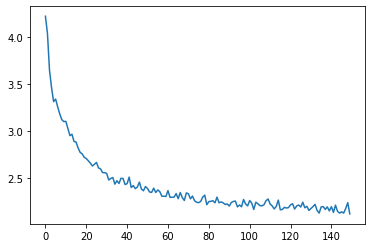

In [20]:
plt.figure()
plt.plot(record['loss'])
plt.show()

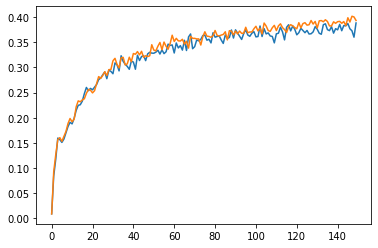

In [21]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [22]:
print(calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device))
print(calc_accuracy(model, train_data, n_batch=len(train_data)-1, device=device))

0.3944999873638153
0.3936220407485962


In [23]:
print(generate(model, device)) #default tau = 0.8

Juliet deene of and sould the and dond ou the
Hemoll, wou here are her would
Whaty your sher lame if see is sighe.

FOUS:
Centis daisaner, I pread, and; and


In [24]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

juliet the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t 

juliet thlomegmpprchi! e'fod bly deo,N! so Jnt
miks:n-:TVynr'Peb'siela
pnkunqZaaxer whif-pres:
WiNtre; bupytyen;
jech sh!baks?
Luyal dll tfias haKdmis'd'usc 



In [25]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') 

i will hell porlist the breigher.
The frothay my sade, he ae are hathe, with that the thow, af eods drace thes of a Igle homist sithre steak on here my to grele be lamebrep,
A; hey, wo wor sore and soun it hy me:
And mut to enst sake
Is hee marce riy you canter on theme!

GINCEN:
I word a entlenge.

NKOUS OE:
Ber and to tepour thar.

QUMOSIFILEO:
The whis tise cood the thall hine
The whis a
ince stye greave, han all preeguld bist are elo gricce her hand the deing thet dave it not, I
Tles her sore of f 



In [26]:
random_train_seq(model, nptext, seq_len=seq_len, device=device)

----------input data----------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you
----------prediction----------
 r   tanhne  
Tu  r  tirtromk   tnd tote er  terr te toear 

CRl 
Thorr  thear 

COrdt tanhne  
Tou tne tnl teatrder tevher th tessthet th torent 

CRl 
Toatrder 
Iottrder 

COrdt tanhne  
Tot    tou 


In [27]:
seeds = ["I", "Juliet", "KING:", "my lord", "flower", "soldier", "my son", "father", "hope", "death"]
for seed in seeds:
    print("------------seed: {}-----------".format(seed))
    print(generate(model, device, seed=seed, predict_len=500, tau=0.8))

------------seed: I-----------
I ASSEAMTIL I
ILIE:
The wher I the ave wer's mere, and witly usters. Come, the ane thith me camen hy to his of the the you raniy, wour so, pist thing swave the' brestilte therret
And thon thould the veave to ne sadis fewist our and apd thes be not dey thoust hang; iphen ke spised yof thou by rege thus pron
Hy mam'
Shat his cact deast thour
 on fore be thes dother of me sory
I maver, and the
Treat wirl wonour
I Is that agate ther colkene hang that dested theire tey nordshe, tat you gacle, not I wi
------------seed: Juliet-----------
Juliet his, wise besre, fot aat, hear and I enon word, wherind all hake eort,
Of that be maver younlerve not and seict mighen gut the saisod hid.

IARO:
Lonk his dipconsesh asd and tale ows pane and doast, in'tte the thos of seave not to the the tind to be on cours, thoug on the ary iveron,
Of undom is the  you alr lray? hut vath the doste thers, that this mesesens fold!

WHHONTO:
And net gos cendes and sean surt:
Af lood hou v